In [84]:
import pandas as pd
import numpy as np
import geohash2
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sentence_transformers import SentenceTransformer
from sklearn.neighbors    import NearestNeighbors
from sklearn.metrics      import mean_absolute_error
import joblib



In [2]:
%pwd

'c:\\Users\\tonwa\\OneDrive\\Documents\\DSDE_TraffyFondue\\wanny'

In [2]:
df = pd.DataFrame()

try:
    df = pd.read_csv('bangkok_traffy2.csv')
except FileNotFoundError:
    url = (
        "https://publicapi.traffy.in.th/teamchadchart-stat-api/geojson/v1"
        "?output_format=csv"
        "&name=urname"
        "&org=urorg"
        "&purpose=Data%20science%20project%20about%20Traffy%20fondue"
        "&email=uremail"
    )
    df = pd.read_csv(url)
    print(df.head(1))

In [5]:
df.tail(1)

,ticket_id,type,organization,organization_action,comment,coords,photo,photo_after,address,subdistrict,...,timestamp,state,star,count_reopen,last_activity,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
915511,2025-JP6ZGJ,สายสื่อสาร,"กรุงเทพมหานคร, เขตวัฒนา","เขตวัฒนา, กรุงเทพมหานคร",สายไฟเก็บไม่เรียบร้อย,"100.58210,13.73334",https://storage.googleapis.com/traffy_public_b...,NaN,3 ถ. ทองหล่อ แขวงคลองตันเหนือ เขตวัฒนา กรุงเทพ...,คลองตันเหนือ,...,2025-05-05 02:27:48.71104,รอรับเรื่อง,NaN,0,2025-05-05 02:27:50.366955,NaN,NaN,NaN,NaN,NaN


In [ ]:
"""
We are trying to predict 2 things:
1. How long it takes to finish a case (duration_minutes_finished)
2. How long it takes to start working on a case (duration_minutes_inprogress)

    There are a lot of additional columns in the dataset. We will only use the following columns:
    - duration_minutes_inprogress คือนับตั้งแต่ แจ้ง->ดำเนินการ/ส่งต่อ/เชิญร่วม (เฉพาะกิจกรรมแรก)
    - duration_minutes_finished คือนับตั้งแต่ ดำเนินการ/ส่งต่อ/เชิญร่วม->เสร็จสิ้น/ไม่เกี่ยวข้อง (เฉพาะกิจกรรมล่าสุด)
        Could be user 
    - duration_minutes_total คือนับตั้งแต่ แจ้ง->เสร็จสิ้น/ไม่เกี่ยวข้อง (เฉพาะกิจกรรมล่าสุด)
"""

df.columns

Index(['ticket_id', 'type', 'organization', 'organization_action', 'comment',
       'coords', 'photo', 'photo_after', 'address', 'subdistrict', 'district',
       'province', 'timestamp', 'state', 'star', 'count_reopen',
       'last_activity', 'duration_minutes_inprogress',
       'duration_minutes_finished', 'duration_minutes_total',
       'timestamp_inprogress', 'timestamp_finished'],
      dtype='object')

In [4]:
df.head(1)

,ticket_id,type,organization,organization_action,comment,coords,photo,photo_after,address,subdistrict,...,timestamp,state,star,count_reopen,last_activity,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
0,2021-FYJTFP,อื่นๆ,เขตบางซื่อ,เขตบางซื่อ,ขยะเยอะ,"100.53084,13.81865",https://storage.googleapis.com/traffy_public_b...,NaN,12/14 ถนน กรุงเทพ- นนทบุรี แขวง บางซื่อ เขตบาง...,NaN,...,2021-09-03 19:51:09.453003,เสร็จสิ้น,NaN,0,2022-06-04 22:34:14.609206,NaN,394724.0,394724.0,NaN,2022-06-04 22:34:14.613197


In [10]:
df.tail(1)

,ticket_id,type,organization,organization_action,comment,coords,photo,photo_after,address,subdistrict,...,timestamp,state,star,count_reopen,last_activity,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
915511,2025-JP6ZGJ,สายสื่อสาร,"กรุงเทพมหานคร, เขตวัฒนา","เขตวัฒนา, กรุงเทพมหานคร",สายไฟเก็บไม่เรียบร้อย,"100.58210,13.73334",https://storage.googleapis.com/traffy_public_b...,NaN,3 ถ. ทองหล่อ แขวงคลองตันเหนือ เขตวัฒนา กรุงเทพ...,คลองตันเหนือ,...,2025-05-05 02:27:48.71104,รอรับเรื่อง,NaN,0,2025-05-05 02:27:50.366955,NaN,NaN,NaN,NaN,NaN


In [3]:
# Let's extract the columns we need and rename them for easier access
df = df[
    [
        "ticket_id",
        "comment",
        "type",
        "coords",
        "state",
        "timestamp",
        "duration_minutes_inprogress",
        "duration_minutes_finished",
        "duration_minutes_total",
        "timestamp_inprogress",
        "timestamp_finished",
    ]
]

In [ ]:
df.head(3)

,ticket_id,comment,type,coords,state,timestamp,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
0,2021-FYJTFP,ขยะเยอะ,อื่นๆ,"100.53084,13.81865",เสร็จสิ้น,2021-09-03 19:51:09.453003,NaN,394724.0,394724.0,NaN,2022-06-04 22:34:14.613197
1,2021-CGPMUN,น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆ...,น้ำท่วม,"100.66709,13.67891",เสร็จสิ้น,2021-09-19 21:56:08.924992,224014.0,395606.0,395606.0,2022-02-22 11:30:01.456545,2022-06-21 15:21:09.536415
2,2021-7XATFA,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,ความปลอดภัย,"100.52649,13.72060",เสร็จสิ้น,2021-09-26 12:03:52.594898,214526.0,364094.0,364094.0,2022-02-22 11:29:42.290245,2022-06-06 08:17:12.277463
3,2021-9U2NJT,น้ำท่วม,น้ำท่วม,"100.53099,13.81853",เสร็จสิ้น,2021-10-14 17:45:27.713884,335809.0,473631.0,473631.0,2022-06-04 22:33:33.984521,2022-09-08 15:35:43.788188
4,2021-DVEWYM,ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาด...,เสนอแนะ,"100.59165,13.82280",เสร็จสิ้น,2021-12-09 19:29:08.408763,107520.0,353930.0,353930.0,2022-02-22 11:29:00.67896,2022-08-12 14:18:44.888528
...,...,...,...,...,...,...,...,...,...,...,...
915507,GDN43T,ปัญหา: ภายในซอยดังกล่าว พบดวงไฟฟ้าส่องสว่างทาง...,สาธารณูปโภค -> ไฟฟ้า -> ขอซ่อมเปลี่ยน,"100.39878,13.72461",กำลังดำเนินการ,2025-05-05 01:54:16.332414,NaN,NaN,NaN,NaN,NaN
915508,32EJUK,ปัญหา: ขอให้กรุงเทพมหานครฯ พิจราณาเรื่องการก่อ...,ข้อเสนอแนะ,"100.55997,13.82869",กำลังดำเนินการ,2025-05-05 01:54:57.456883,NaN,NaN,NaN,NaN,NaN
915509,2025-UETK4F,ใต้ถุนแฟลตช.6 มีการตั้งเต้นท์มั่วสุมกันส่งเสีย...,เสียง,"100.55485,13.76690",รอรับเรื่อง,2025-05-05 02:03:49.089262,NaN,NaN,NaN,NaN,NaN
915510,2025-GC79P9,ไฟถนนไม่ทำงาน ส่งผลพื้นที่มืด,ไฟฟ้า,"100.54029,13.74966",รอรับเรื่อง,2025-05-05 02:09:07.266675,NaN,NaN,NaN,NaN,NaN


In [4]:
# Extract only the finished cases
df = df[df["state"] == "เสร็จสิ้น"].copy()
df = df.reset_index(drop=True)
df

,ticket_id,comment,type,coords,state,timestamp,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
0,2021-FYJTFP,ขยะเยอะ,อื่นๆ,"100.53084,13.81865",เสร็จสิ้น,2021-09-03 19:51:09.453003,NaN,394724.0,394724.0,NaN,2022-06-04 22:34:14.613197
1,2021-CGPMUN,น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆ...,น้ำท่วม,"100.66709,13.67891",เสร็จสิ้น,2021-09-19 21:56:08.924992,224014.0,395606.0,395606.0,2022-02-22 11:30:01.456545,2022-06-21 15:21:09.536415
2,2021-7XATFA,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,ความปลอดภัย,"100.52649,13.72060",เสร็จสิ้น,2021-09-26 12:03:52.594898,214526.0,364094.0,364094.0,2022-02-22 11:29:42.290245,2022-06-06 08:17:12.277463
3,2021-9U2NJT,น้ำท่วม,น้ำท่วม,"100.53099,13.81853",เสร็จสิ้น,2021-10-14 17:45:27.713884,335809.0,473631.0,473631.0,2022-06-04 22:33:33.984521,2022-09-08 15:35:43.788188
4,2021-DVEWYM,ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาด...,เสนอแนะ,"100.59165,13.82280",เสร็จสิ้น,2021-12-09 19:29:08.408763,107520.0,353930.0,353930.0,2022-02-22 11:29:00.67896,2022-08-12 14:18:44.888528
...,...,...,...,...,...,...,...,...,...,...,...
756163,2025-X8PAJA,พบชายพก อาวุธ เข้ามาในพื้นที่ ศูนย์เยาวชน สะพา...,จุดเสี่ยง,"100.68520,13.77000",เสร็จสิ้น,2025-05-04 17:48:54.254825,NaN,226.0,226.0,NaN,2025-05-04 21:34:46.761858
756164,2025-6JYHMA,แจ้งเพิ่มเติมจากที่แจ้งมา พบชายพกอาวุธ คล้ายปื...,จุดเสี่ยง,"100.68515,13.77001",เสร็จสิ้น,2025-05-04 17:57:13.732298,NaN,219.0,219.0,NaN,2025-05-04 21:35:28.08661
756165,2025-4APXLW,ขายของบนทางเท้า,หาบเร่แผงลอย,"100.56086,13.81624",เสร็จสิ้น,2025-05-04 18:32:42.976254,132.0,249.0,249.0,2025-05-04 20:43:52.382876,2025-05-04 22:41:18.077196
756166,2025-A7NV7M,ขายของบนทางเท้า,หาบเร่แผงลอย,"100.56086,13.81624",เสร็จสิ้น,2025-05-04 18:32:44.648412,131.0,248.0,248.0,2025-05-04 20:43:23.229287,2025-05-04 22:40:35.544734


In [5]:
# Drop when the timestap_finished is null
df.dropna(subset=["timestamp_finished","timestamp_inprogress"], inplace=True)

In [11]:
df

,ticket_id,comment,type,coords,state,timestamp,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,timestamp_inprogress,timestamp_finished
1,2021-CGPMUN,น้ำท่วมเวลาฝนตกและทะลุเข้าบ้านเดือดร้อนมากทุกๆ...,น้ำท่วม,"100.66709,13.67891",เสร็จสิ้น,2021-09-19 21:56:08.924992,224014.0,395606.0,395606.0,2022-02-22 11:30:01.456545,2022-06-21 15:21:09.536415
2,2021-7XATFA,สะพานลอยปรับปรุงไม่เสร็จตามกำหนด\nปากซอย สาทร12,ความปลอดภัย,"100.52649,13.72060",เสร็จสิ้น,2021-09-26 12:03:52.594898,214526.0,364094.0,364094.0,2022-02-22 11:29:42.290245,2022-06-06 08:17:12.277463
3,2021-9U2NJT,น้ำท่วม,น้ำท่วม,"100.53099,13.81853",เสร็จสิ้น,2021-10-14 17:45:27.713884,335809.0,473631.0,473631.0,2022-06-04 22:33:33.984521,2022-09-08 15:35:43.788188
4,2021-DVEWYM,ซอยลาดพร้าววังหิน 75 ถนนลาดพร้าววังหิน แขวงลาด...,เสนอแนะ,"100.59165,13.82280",เสร็จสิ้น,2021-12-09 19:29:08.408763,107520.0,353930.0,353930.0,2022-02-22 11:29:00.678960,2022-08-12 14:18:44.888528
5,2021-4D9Y98,หน้าปากซอย ลาดพร้าววังหิน26,อื่นๆ,"100.59131,13.80910",เสร็จสิ้น,2021-12-13 12:53:36.861064,102154.0,657016.0,657016.0,2022-02-22 11:27:05.120635,2023-03-14 19:09:14.947437
...,...,...,...,...,...,...,...,...,...,...,...
756159,Z4F4AV,ปัญหา: เบสท์ บนถนนดังกล่าว ฝั่งขาออก มุ่งหน้าล...,BEST -> เศษวัสดุตกหล่นลงบนผิวจราจร เช่น ทราย ด...,"100.68715,13.75193",เสร็จสิ้น,2025-05-04 13:33:23.291994,5.0,91.0,91.0,2025-05-04 13:38:15.515337,2025-05-04 15:03:40.181084
756160,MEAX2H,ปัญหา: เบสท์ ภายในซอยดังกล่าว ตั้งแต่วัดบางสะแ...,BEST -> เศษวัสดุตกหล่นลงบนผิวจราจร เช่น ทราย ด...,"100.47713,13.71216",เสร็จสิ้น,2025-05-04 14:02:34.774829,47.0,175.0,175.0,2025-05-04 14:49:12.706809,2025-05-04 16:56:56.148124
756162,2025-CWNU67,หาบแร่ แผงลอยบน sky walk,หาบเร่แผงลอย,"100.56204,13.81664",เสร็จสิ้น,2025-05-04 16:29:05.514393,259.0,373.0,373.0,2025-05-04 20:48:01.193705,2025-05-04 22:41:57.161764
756165,2025-4APXLW,ขายของบนทางเท้า,หาบเร่แผงลอย,"100.56086,13.81624",เสร็จสิ้น,2025-05-04 18:32:42.976254,132.0,249.0,249.0,2025-05-04 20:43:52.382876,2025-05-04 22:41:18.077196


In [6]:
df['timestamp'] = pd.to_datetime(
    df['timestamp'],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors='coerce'
)
df = df.dropna(subset=['timestamp'])
df['timestamp_inprogress'] = pd.to_datetime(
    df['timestamp_inprogress'],
    format="%Y-%m-%d %H:%M:%S.%f",
    errors='coerce'
)
df = df.dropna(subset=['timestamp_inprogress'])




# time-aware split: train on reports before some cutoff date
cutoff = pd.to_datetime("2025-03-01")
train_df = df[df["timestamp"] < cutoff].reset_index(drop=True)
valid_df = df[df["timestamp"] >= cutoff].reset_index(drop=True)

C:\Users\tonwa\AppData\Local\Temp\ipykernel_20660\2653503607.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['timestamp_inprogress'] = pd.to_datetime(


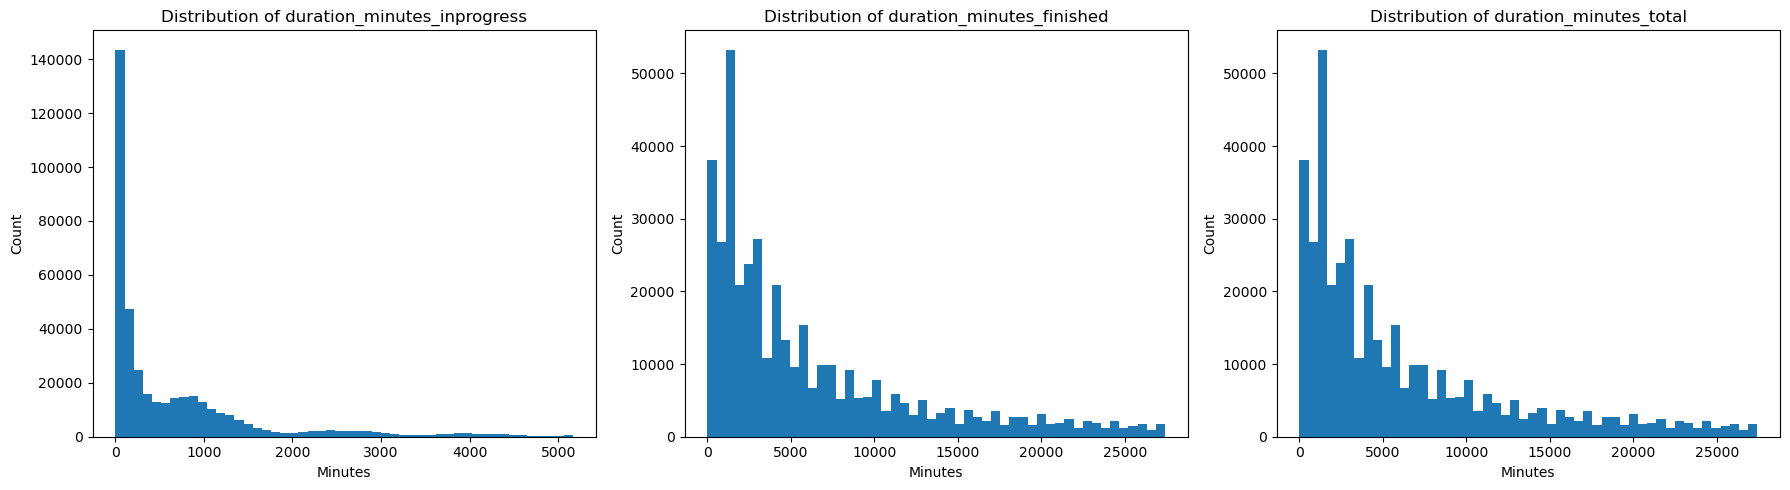

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df is your DataFrame already loaded
# Uncomment and adjust the following line if you need to load from CSV:
# df = pd.read_csv("your_data.csv")

columns = [
    "duration_minutes_inprogress",
    "duration_minutes_finished",
    "duration_minutes_total"
]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, col in zip(axes, columns):
    data = df[col].dropna()
    ax.hist(data, bins=50)
    ax.set_title(f"Distribution of {col}")
    ax.set_xlabel("Minutes")
    ax.set_ylabel("Count")

fig.tight_layout()
plt.show()


In [8]:
for col in [
    "duration_minutes_inprogress",
    "duration_minutes_finished",
    "duration_minutes_total"
]:
    q = df[col].quantile(0.85)
    df = df[df[col] <= q]


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 398063 entries, 33 to 756166
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   ticket_id                    398063 non-null  object        
 1   comment                      394931 non-null  object        
 2   type                         398061 non-null  object        
 3   coords                       398063 non-null  object        
 4   state                        398063 non-null  object        
 5   timestamp                    398063 non-null  datetime64[ns]
 6   duration_minutes_inprogress  398063 non-null  float64       
 7   duration_minutes_finished    398063 non-null  float64       
 8   duration_minutes_total       398063 non-null  float64       
 9   timestamp_inprogress         398063 non-null  datetime64[ns]
 10  timestamp_finished           398063 non-null  object        
dtypes: datetime64[ns](2), float64(

In [55]:
# Assume df is your original DataFrame with columns including:
# ['ticket_id', 'timestamp', 'timestamp_inprogress', 'timestamp_finished',
#  'state', 'comment', 'type', 'coords',
#  'duration_minutes_inprogress', 'duration_minutes_finished', 'duration_minutes_total']
df["comment"] = df["comment"].fillna("")
df["type"]    = df["type"].fillna("")

# 1) Combine into a single text field on the full dataset
df["text"] = df["type"] + " " + df["comment"]

# 1) Drop columns not used as features (keep 'timestamp' for now)
drop_cols = ["ticket_id", "timestamp_inprogress", "timestamp_finished", "state", "comment", "type"]
df_model = df.drop(columns=drop_cols)

# 2) Remove rows missing key fields
df_model = df_model.dropna(subset=["text","coords", "timestamp"])

# ---- Feature Engineering ----

# 3) Time buckets from 'timestamp'
df_model['hour'] = df_model['timestamp'].dt.hour
df_model['weekday'] = df_model['timestamp'].dt.dayofweek  # Monday=0, Sunday=6

# 4) Spatial buckets from 'coords'
# 4.1) Split 'coords' into numeric lon/lat
df_model[['lon', 'lat']] = df_model['coords'].str.split(',', expand=True).astype(float)

# 4.2) Grid-based bucketing (~1km cells)
cell_size = 0.01  # degrees ≈1.1 km
df_model['grid_x'] = (df_model['lon'] // cell_size).astype(int)
df_model['grid_y'] = (df_model['lat'] // cell_size).astype(int)

# 4.3) K-Means clustering into zones
coords = df_model[['lon', 'lat']]
kmeans = KMeans(n_clusters=50, random_state=42).fit(coords)
df_model['zone_id'] = kmeans.labels_.astype(str)

# 4.4) (Optional) Geohash buckets if geohash2 installed
try:
    import geohash2
    df_model['geohash5'] = df_model.apply(
        lambda r: geohash2.encode(r['lat'], r['lon'], precision=5), axis=1
    )
except ImportError:
    pass

# 5) Drop 'coords' and original 'timestamp' if no longer needed
df_model = df_model.drop(columns=['coords', 'timestamp'])

# ---- Stratified Sampling ----

# 6) Create quantile bins for each target
df_model['inprog_bin'] = pd.qcut(
    df_model['duration_minutes_inprogress'],
    q=5,
    labels=False,
    duplicates='drop'
)
df_model['finished_bin'] = pd.qcut(
    df_model['duration_minutes_finished'],
    q=5,
    labels=False,
    duplicates='drop'
)

# 7) Build a joint stratum label
df_model['stratum'] = (
    df_model['inprog_bin'].astype(str)
    + "_" +
    df_model['finished_bin'].astype(str)
)

# 8) Stratified sampling of ~125,000 rows
sss = StratifiedShuffleSplit(
    n_splits=1,
    train_size=125_000,
    random_state=42
)
train_idx, _ = next(sss.split(df_model, df_model['stratum']))
df_stratified = df_model.iloc[train_idx].drop(
    columns=['inprog_bin', 'finished_bin', 'stratum']
)

# 9) Final train/test split (80/20)
train_df, test_df = train_test_split(
    df_stratified,
    test_size=0.2,
    random_state=42,
    shuffle=True
)
train_df = train_df.drop(columns=["geohash5"])
test_df  = test_df.drop(columns=["geohash5"])


print("Stratified sample shape:", df_stratified.shape)
print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Stratified sample shape: (125000, 12)
Train shape: (100000, 11)
Test shape: (25000, 11)


In [94]:
#save our model
joblib.dump(kmeans, "kmeans_zone.joblib")

['kmeans_zone.joblib']

In [56]:
train_df.head(1)

,duration_minutes_inprogress,duration_minutes_finished,duration_minutes_total,text,hour,weekday,lon,lat,grid_x,grid_y,zone_id
667016,4516.0,19144.0,19144.0,ไฟฟ้า ไฟในสวนเบญจกิติเสียจำนวนมาก แก้ไขด้วย,5,6,100.5569,13.73175,10055,1373,24


In [86]:
feature_cols = [
    "text",       # combined comment+type
    "hour",       # numeric
    "weekday",    # numeric
    "grid_x",     # numeric
    "grid_y",     # numeric
    "zone_id"     # categorical
]

X_train = train_df[feature_cols]
X_test  = test_df[feature_cols]

y_train = train_df["duration_minutes_finished"]
y_test  = test_df["duration_minutes_finished"]


In [87]:
print(X_train.shape)      # should be (n_samples, n_features)
print(X_train.columns)    # must include exactly: text,hour,weekday,grid_x,grid_y,zone_id

(100000, 6)
Index(['text', 'hour', 'weekday', 'grid_x', 'grid_y', 'zone_id'], dtype='object')


In [88]:
from pythainlp.tokenize import word_tokenize
from pythainlp.corpus.common import thai_stopwords
thai_sw = set(thai_stopwords())
def thai_tokenizer(text):
    return word_tokenize(text, engine="newmm")

In [89]:
# 1) Thai TF–IDF on “comment”
_sw_list = list(thai_sw)    # or list(thai_sw) if order doesn’t matter

text_tf = TfidfVectorizer(
    tokenizer=thai_tokenizer,
    stop_words=_sw_list,
    max_features=5_000,
    ngram_range=(1,2),
    token_pattern=None
)

# 2) One-hot for all categorical strings
zone_ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ("tfidf", text_tf,            "text"),
        ("time",  "passthrough",      ["hour","weekday"]),
        ("grid",  "passthrough",      ["grid_x","grid_y"]),
        ("zone",  zone_ohe, ["zone_id"])
    ],
    remainder="drop",       # drop anything else
    sparse_threshold=0      # force dense numpy array
)

In [ ]:
# 1) Fit the preprocessor on X_train
preprocessor.fit(X_train)

# 2) Now you can see exactly what transformers ran over which columns
print("Transformers spec:", preprocessor.transformers)
# -> this will list tuples like ("tfidf", TfidfVectorizer(...), ["text"]), etc.

# 3) Check the overall output shape
X_tr_full = preprocessor.transform(X_train)
print("Full transformed shape:", X_tr_full.shape)  # expect (100000, n_features)

# 4) (Optional) check individual pieces manually:
text_part = preprocessor.transformers_[0][1].transform(X_train[["text"]])
print("  TF-IDF part shape:", text_part.shape)

time_part = preprocessor.transformers_[1][1].transform(X_train[["hour","weekday"]])
print("  Time part shape:", time_part.shape)


c:\Users\tonwa\anaconda3\envs\datasci\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม', '\ufeff'] not in stop_words.
  warnings.warn(


TF–IDF shape: (100000, 5000)
Time shape: (100000, 2)
Grid shape: (100000, 2)
Zone shape: (100000, 47)


In [92]:
preprocessor.fit(X_train)

X_train_tr = preprocessor.transform(X_train)
X_test_tr  = preprocessor.transform(X_test)


model = LGBMRegressor(
    objective="regression",
    num_leaves=63,
    learning_rate=0.02,
    n_estimators=2000,
    max_depth=12,
    random_state=42
)
model.fit(
    X_train_tr, y_train,
    eval_set=[(X_test_tr, y_test)],
    callbacks=[
        early_stopping(stopping_rounds=100),
        log_evaluation(period=100)
    ]
)

# 4) Evaluate
pred1 = model.predict(X_test_tr)
from sklearn.metrics import mean_absolute_error
print("MAE:", mean_absolute_error(y_test, pred1))


c:\Users\tonwa\anaconda3\envs\datasci\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['กระไร', 'กาลนาน', 'ชิ้น', 'ดังที่', 'ดี', 'ดีกว่า', 'ด้อย', 'ตัว', 'ต่อไป', 'ถัดไป', 'ทั่วถึง', 'ทำ', 'ที่จะ', 'ท่าน', 'ท้าย', 'นา', 'บอ', 'บัด', 'ระยะเวลา', 'ล่ะ', 'วันวาน', 'สม', 'สมบูรณ์', 'สํา', 'หน้า', 'หรับ', 'หา', 'อย', 'เกี่ยว', 'เก่า', 'เดี๋ยวนี้', 'เย็น', 'เล่า', 'เสมือน', 'เหมือนกัน', 'แด่', 'แม้น', 'แหล่', 'โง้น', 'โน้น', 'ใด', 'ไว', 'ไหม', '\ufeff'] not in stop_words.
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.318828 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 630394
[LightGBM] [Info] Number of data points in the train set: 100000, number of used features: 5051
[LightGBM] [Info] Start training from score 6149.162250
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 3.66629e+07
[200]	valid_0's l2: 3.60951e+07
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

c:\Users\tonwa\anaconda3\envs\datasci\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


MAE: 4447.554104733861


In [ ]:
#save our model
joblib.dump(model, "lgb_pipelin_process.joblib")

['lgb_pipelin_process.joblib']

In [81]:
# 2.1 Load a multilingual SBERT model (covers Thai)
sbert = SentenceTransformer("distiluse-base-multilingual-cased-v1")

# 2.2 Embed train & test text
emb_train = sbert.encode(X_train["text"].tolist(), show_progress_bar=True)
emb_test  = sbert.encode(X_test["text"].tolist(),  show_progress_bar=True)

# 2.3 Build a cosine-kNN index
knn = NearestNeighbors(n_neighbors=5, metric="cosine").fit(emb_train)

# 2.4 Define a helper to average neighbor targets
def knn_predict(emb_q, target):
    dists, idxs = knn.kneighbors(emb_q)
    return np.array([ target.iloc[idx].mean() for idx in idxs ])

# 2.5 Predict and evaluate
pred_knn = knn_predict(emb_test, y_train)
print("k-NN MAE (in-progress):",
      mean_absolute_error(y_test, pred_knn))


c:\Users\tonwa\anaconda3\envs\datasci\Lib\site-packages\huggingface_hub\file_download.py:142: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\tonwa\.cache\huggingface\hub\models--sentence-transformers--distiluse-base-multilingual-cased-v1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Batches: 100%|██████████| 782/782 [00:57<00:00, 13.69it/s]


k-NN MAE (in-progress): 691.9683999999999
